In [1]:
try:
    # import google.colab # type: ignore
    # from google.colab import output
    %pip install -q transformer-lens matplotlib numpy seaborn torch hf_transfer tqdm scikit-learn
except:
    from IPython import get_ipython  # type: ignore

    ipython = get_ipython()
    assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import json
import random
import transformers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

from grid_functions import *
from transformer_lens import HookedTransformer

import os
# Avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# My imports
from dataset import GridTextDataset
from dataset import get_dataloader
from linear_model import LinearProbe
from analysis import *
from plotting import plot_color_gradients, generate_colormap
from relative_goal_hypothesis import collect_all_activations, collect_activations_table

In [3]:
transformers.__version__

'4.57.3'

## Loading Model

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# if the model is not downloaded, this might be needed

#access_token = "hf_TOKEN"

#tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)
#model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)

In [5]:
# Load the model using transformer-lens
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


## Load Data

In [192]:
# test loading
with open("data/grid_simple_dataset.json", "r") as f:
    loaded_dataset = json.load(f)

Vizualize one point of the dataset on the grid

In [193]:
torch_dataset = GridTextDataset(loaded_dataset, train_ratio=1.0, valid_ratio=0.0)
torch_dataset.__getitem__(0)  # Test getting the first item

train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=8, train_ratio=1.0, valid_ratio=0.0)

Training dataset len: 625
Validation dataset len: 0
Test dataset len: 0


## All layers PCA

In [194]:
import torch
import torch.nn.functional as F
import numpy as np
from grid_functions import generate_simple_example


def collect_all_activations(model, test_loader, device="cuda"):
    # For PCA
    model.eval()

    n_layers = model.cfg.n_layers

    x = []
    y_goal = []
    y_agent = []

    with torch.no_grad():
        for batch in test_loader:
            text = batch["text"]
            goal_grid = batch["goal_grid"].to(device)
            agent_grid = batch["agent_grid"]

            _, cache = model.run_with_cache(text)

            all_acts = [
                cache["resid_pre", layer][:, -1]
                for layer in range(n_layers)
            ]  # list: [batch, hidden]
            all_acts = torch.stack(all_acts, dim=1)

            all_acts = all_acts.reshape(all_acts.shape[0], -1)
            x.append(all_acts.cpu())
            y_goal.append(goal_grid.cpu())
            y_agent.append(agent_grid.cpu())

    return torch.cat(x, dim=0), torch.cat(y_goal, dim=0), torch.cat(y_agent, dim=0)

In [195]:
all_activations_x, y_goals, y_agents = collect_all_activations(model, train_loader)

In [196]:
y_goals_flat = torch.argmax(y_goals, axis=1)
y_agents_flat = torch.argmax(y_agents, axis=1)

In [197]:
reduced_data_pca = PCA(n_components=3).fit_transform(all_activations_x)
cmap = generate_colormap(25)

### Agent position clusters

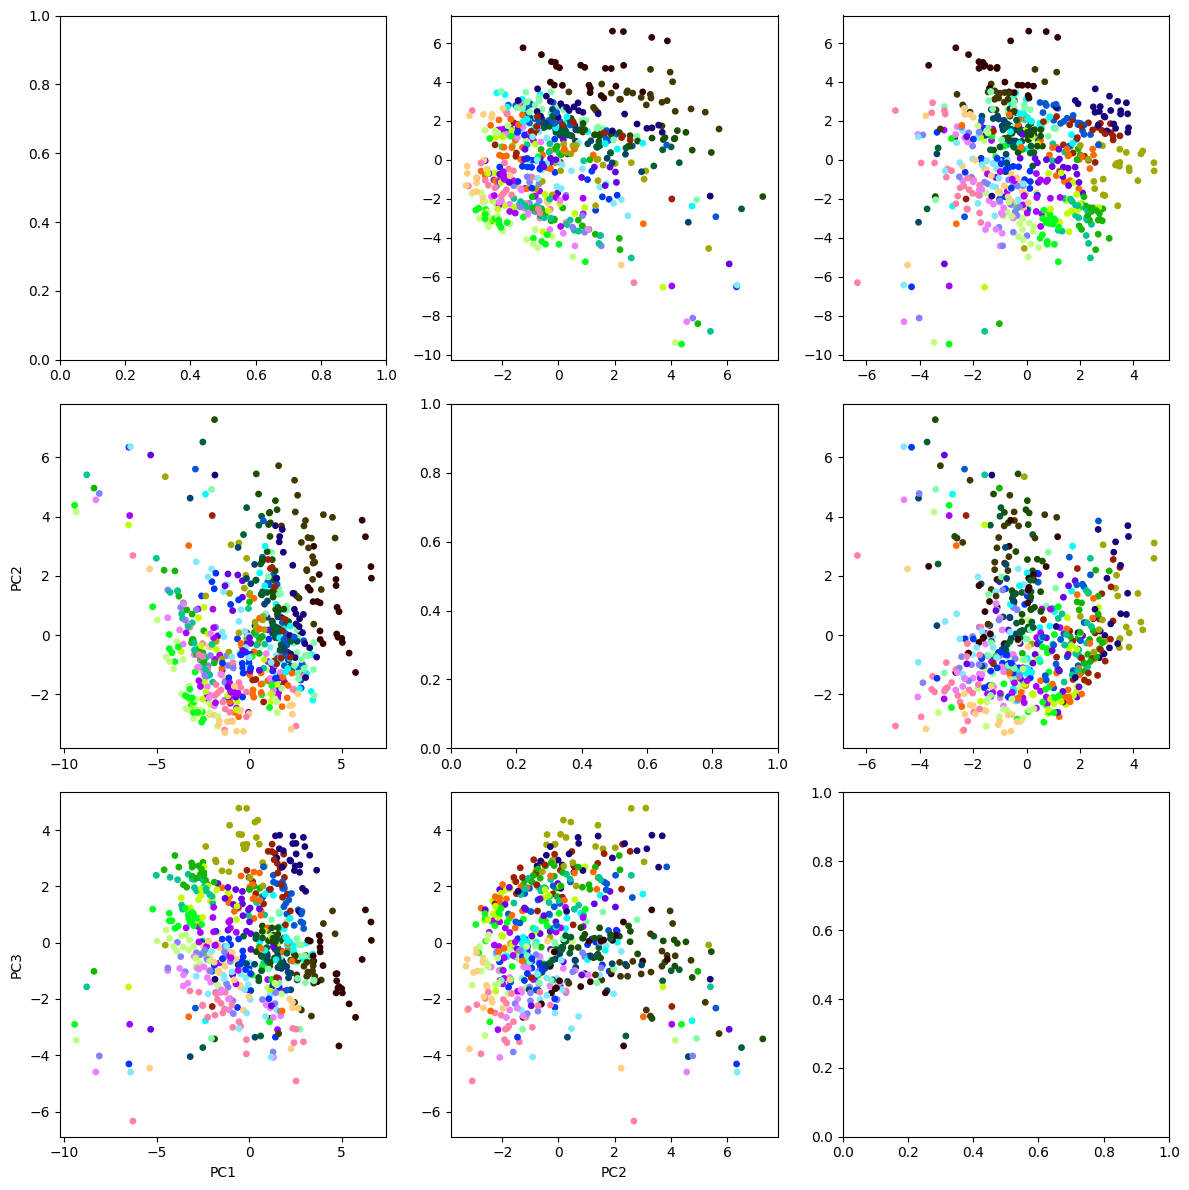

Silhouette score:  -0.04532941923253789
Davies Bouldin Score:  3.947565654932741


In [198]:
# Agent pos
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_agents_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()


score = silhouette_score(reduced_data_pca, y_agents_flat)
db = davies_bouldin_score(reduced_data_pca, y_agents_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)

### Goal position clusters

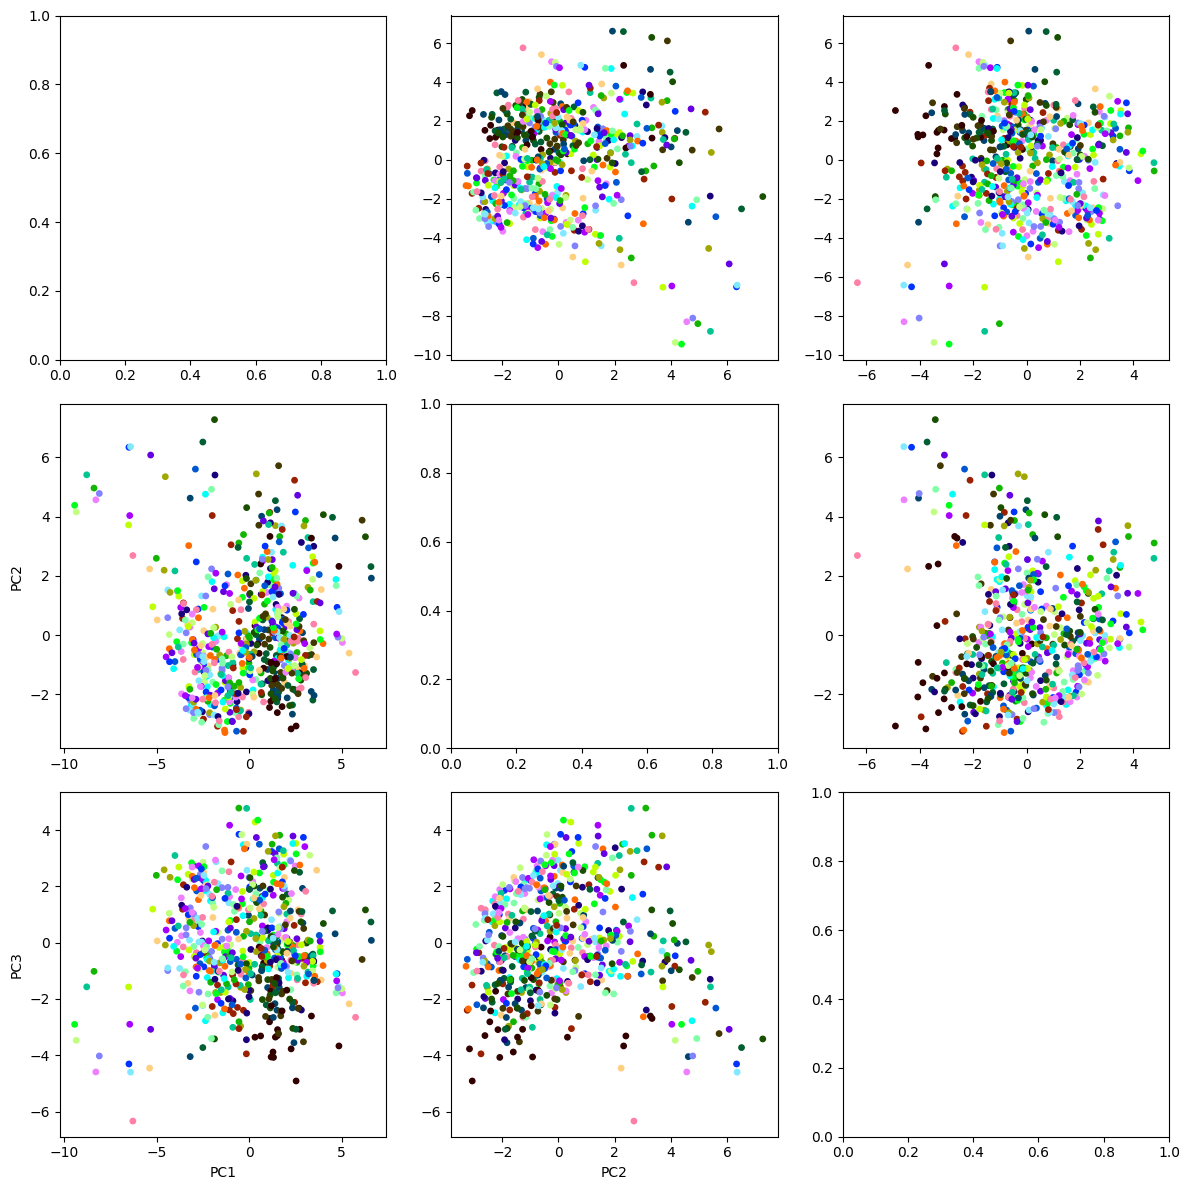

Silhouette score:  -0.144265067232484
Davies Bouldin Score:  24.763109993989993


In [199]:
# Goals pos
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_goals_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()

score = silhouette_score(reduced_data_pca, y_goals_flat)
db = davies_bouldin_score(reduced_data_pca, y_goals_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)

## Layer 29 PCA

In [200]:
import torch
import torch.nn.functional as F
import numpy as np
from grid_functions import generate_simple_example


def collect_all_activations(model, test_loader, device="cuda"):
    # For PCA
    model.eval()

    n_layers = model.cfg.n_layers

    x = []
    y_goal = []
    y_agent = []

    with torch.no_grad():
        for batch in test_loader:
            text = batch["text"]
            goal_grid = batch["goal_grid"].to(device)
            agent_grid = batch["agent_grid"]

            _, cache = model.run_with_cache(text)

            all_acts = [
                cache["resid_pre", 29][:, -1]
            ]  # list: [batch, hidden]
            all_acts = torch.stack(all_acts, dim=1)

            all_acts = all_acts.reshape(all_acts.shape[0], -1)
            x.append(all_acts.cpu())
            y_goal.append(goal_grid.cpu())
            y_agent.append(agent_grid.cpu())

    return torch.cat(x, dim=0), torch.cat(y_goal, dim=0), torch.cat(y_agent, dim=0)

In [201]:
all_activations_x, y_goals, y_agents = collect_all_activations(model, train_loader)

In [202]:
y_goals_flat = torch.argmax(y_goals, axis=1)
y_agents_flat = torch.argmax(y_agents, axis=1)

In [203]:
reduced_data_pca = PCA(n_components=3).fit_transform(all_activations_x)

### Agent pos cluster

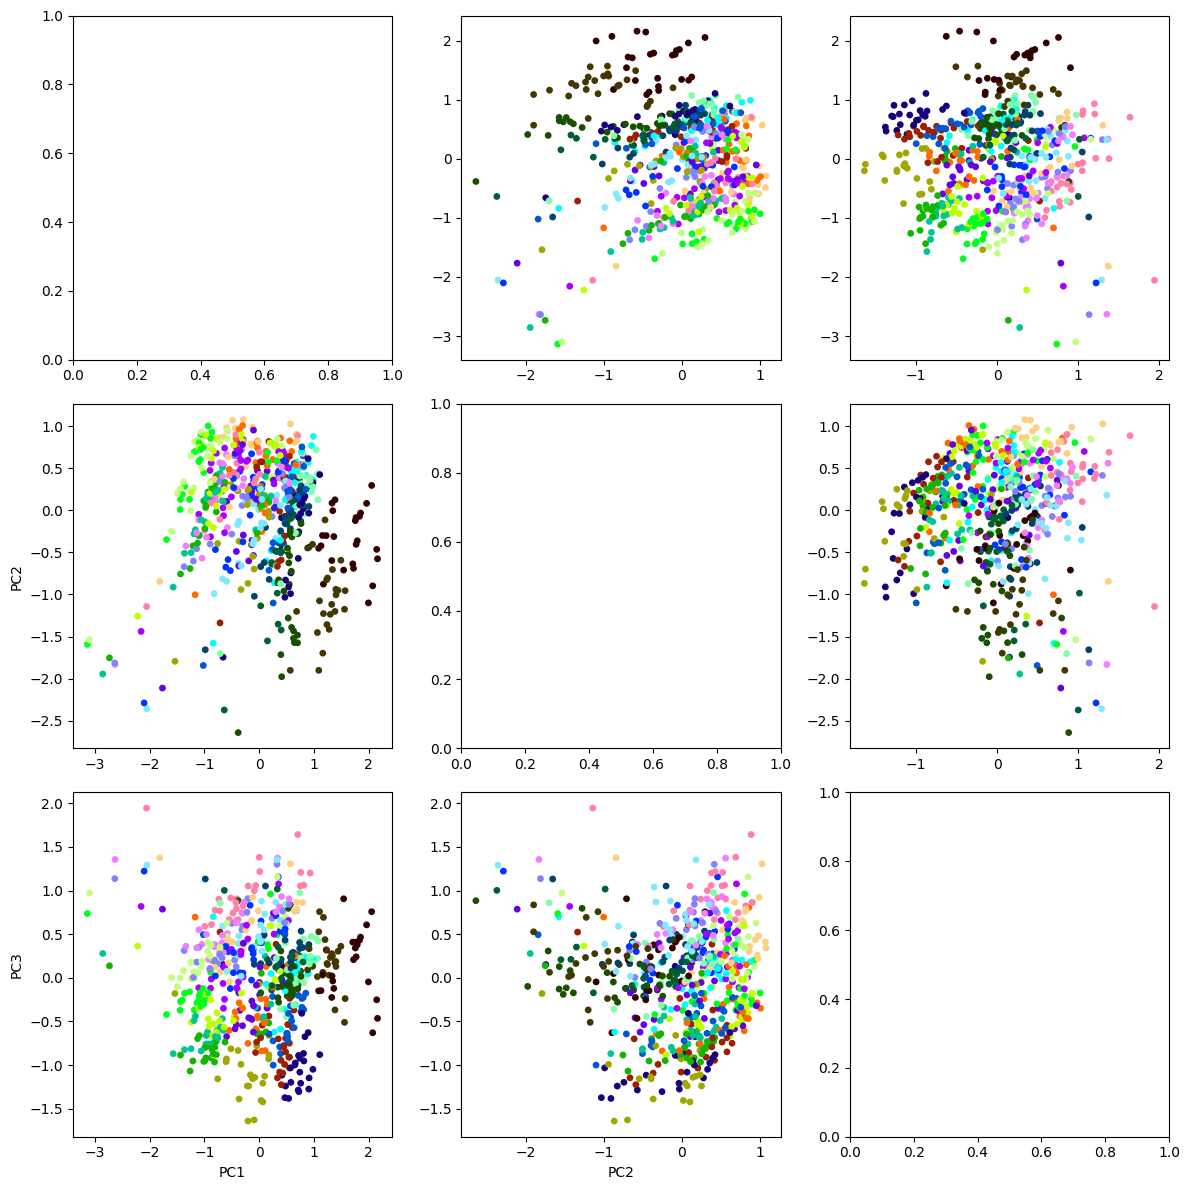

Silhouette score:  -0.04070948136653057
Davies Bouldin Score:  3.9557702383207927


In [204]:
# Agents pos labels
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_agents_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()

score = silhouette_score(reduced_data_pca, y_agents_flat)
db = davies_bouldin_score(reduced_data_pca, y_agents_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)

### Goal pos cluster

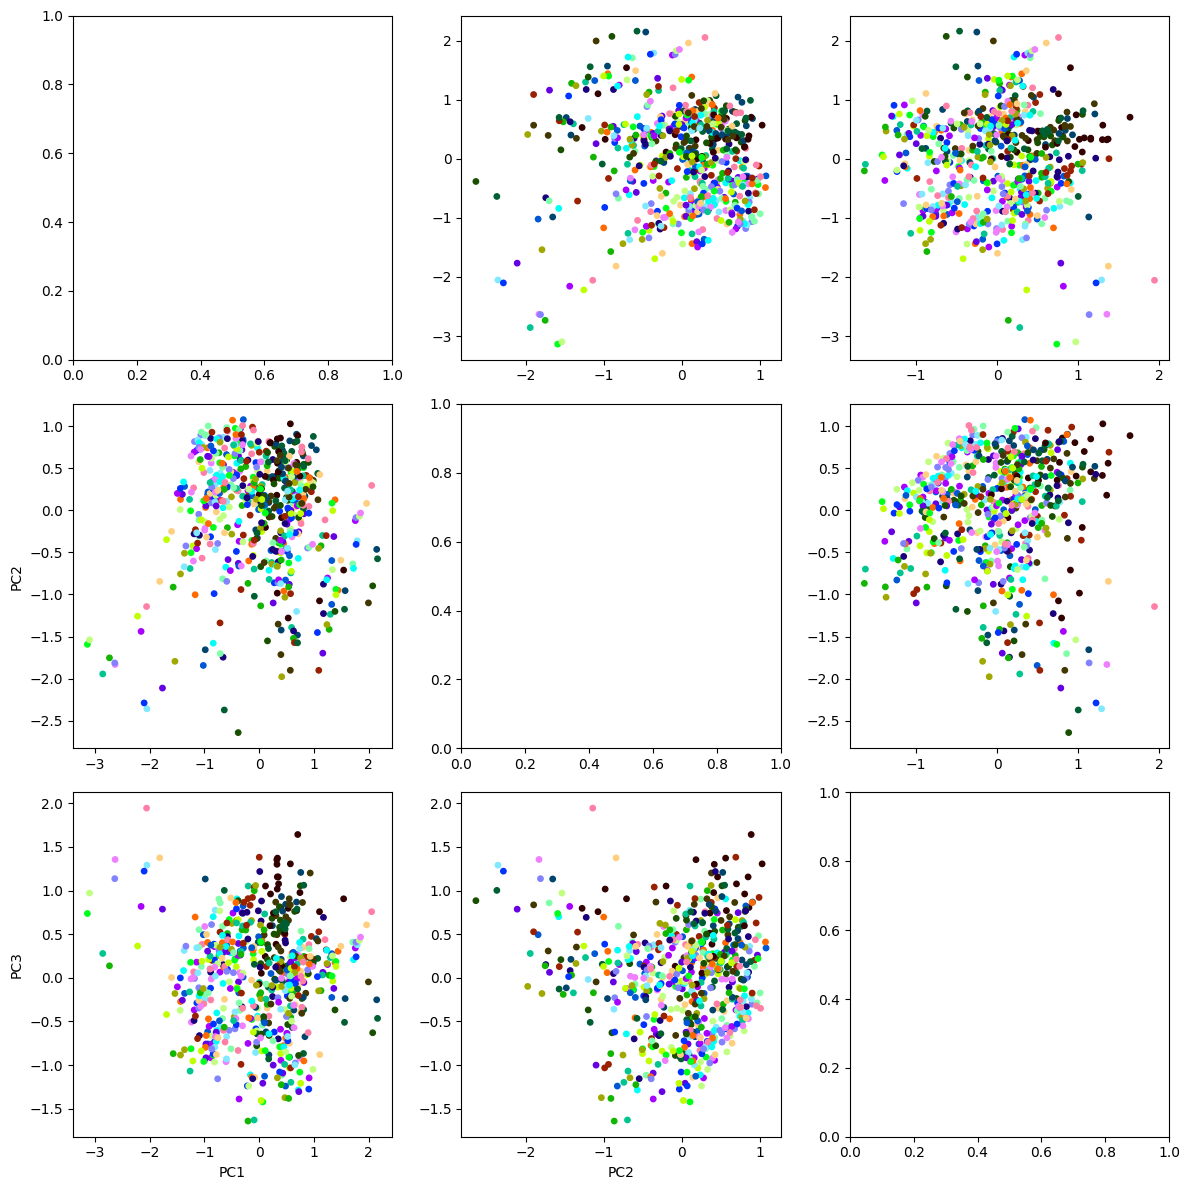

Silhouette score:  -0.14656105044503298
Davies Bouldin Score:  26.441981019505878


In [205]:
# Goals pos labels
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_goals_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()
score = silhouette_score(reduced_data_pca, y_goals_flat)
db = davies_bouldin_score(reduced_data_pca, y_goals_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)

In [206]:
categories_to_keep = torch.tensor([4,])  # example categories

# Create a boolean mask
mask = torch.isin(y_agents_flat, categories_to_keep)

# Apply mask to both tensors
filtered_activations_x = reduced_data_pca[mask]
filtered_y_goals = y_goals[mask]
filtered_y_agents = y_agents[mask][0]
filtered_y_goals_flat = y_goals_flat[mask]
filtered_y_agents_flat = y_agents_flat[mask]

In [207]:
print(filtered_y_goals.shape, filtered_activations_x.shape)
# torch.Size([24, 25]) (24, 3)

torch.Size([25, 25]) (25, 3)


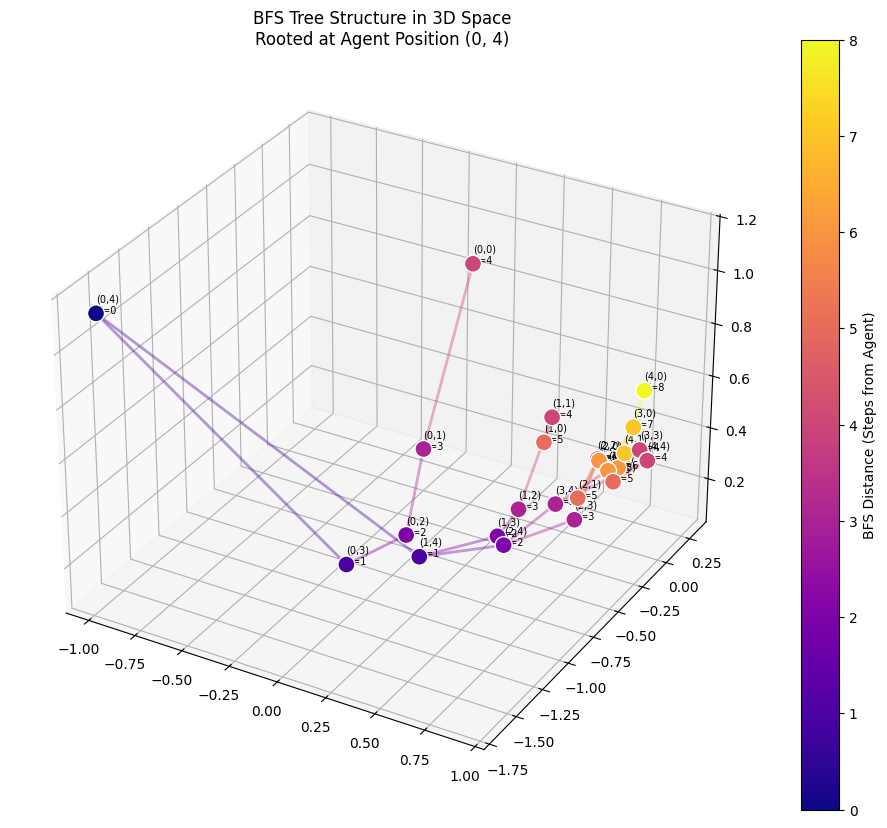

In [208]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# 1. Setup BFS from Agent Location
agent_idx = torch.argmax(filtered_y_agents).item()
ra, ca = divmod(agent_idx, 5)

# Map for easy lookup
idx_to_activation = {idx.item(): filtered_activations_x[i] for i, idx in enumerate(torch.argmax(filtered_y_goals, dim=1))}

# 2. Run BFS to track parent-child relationships
queue = deque([agent_idx])
visited = {agent_idx}
parent_child_links = []
discovery_distances = {agent_idx: 0}

while queue:
    parent = queue.popleft()
    
    # Check neighbors in 5x5 grid
    r, c = divmod(parent, 5)
    for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
        child = (r + dr) * 5 + (c + dc)
        
        if 0 <= r+dr < 5 and 0 <= c+dc < 5 and child not in visited:
            visited.add(child)
            discovery_distances[child] = discovery_distances[parent] + 1
            
            # If both parent and child are in our data, store the link
            if parent in idx_to_activation and child in idx_to_activation:
                parent_child_links.append((parent, child))
            
            queue.append(child)

# 3. Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('plasma')

# Draw lines only to "father nodes"
segments = [[idx_to_activation[p], idx_to_activation[c]] for p, c in parent_child_links]
# Color lines by the child's distance from agent
max_d = max(discovery_distances.values())
line_colors = [(*cmap(discovery_distances[c] / max_d)[:3], 0.4) for p, c in parent_child_links]

lc = Line3DCollection(segments, colors=line_colors, linewidths=2)
ax.add_collection3d(lc)

# Scatter plot of all goals, colored by BFS distance
goal_indices = torch.argmax(filtered_y_goals, dim=1).cpu().numpy()
goal_distances = [discovery_distances.get(idx, 0) for idx in goal_indices]

sc = ax.scatter(
    filtered_activations_x[:, 0], 
    filtered_activations_x[:, 1], 
    filtered_activations_x[:, 2], 
    c=goal_distances, 
    cmap='plasma', 
    s=150, 
    edgecolors='white',
    alpha=1.0
)

# Annotations
for i, idx in enumerate(goal_indices):
    r, c = divmod(idx, 5)
    d = discovery_distances.get(idx, 0)
    ax.text(filtered_activations_x[i,0], filtered_activations_x[i,1], filtered_activations_x[i,2], 
            f"({r},{c})\nd={d}", fontsize=7)

ax.set_title(f'BFS Tree Structure in 3D Space\nRooted at Agent Position ({ra}, {ca})')
plt.colorbar(sc, label='BFS Distance (Steps from Agent)')
plt.show()

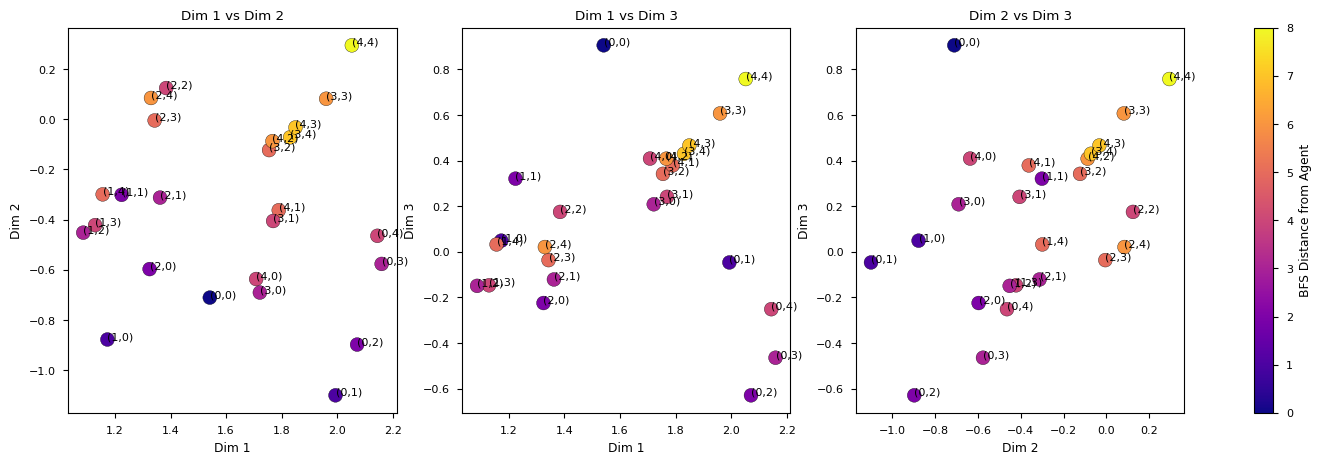

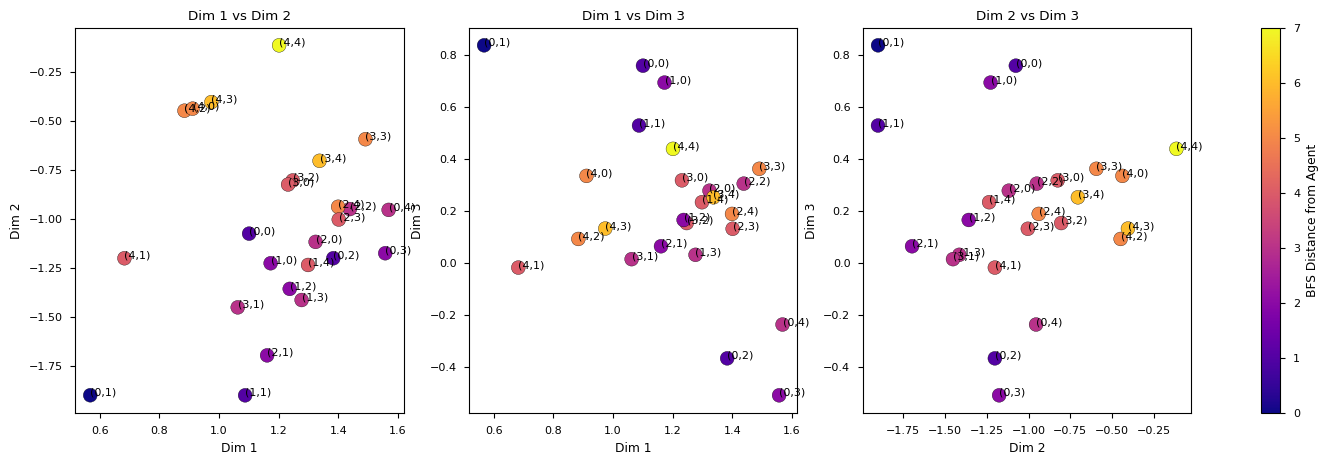

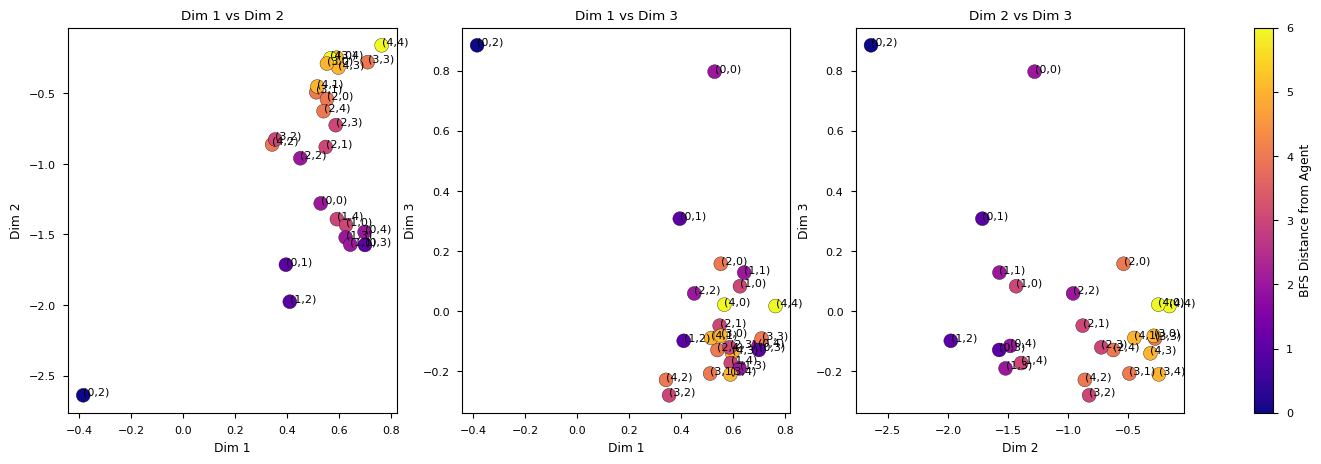

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch

for agent_pos_i in range(3):

    categories_to_keep = torch.tensor([agent_pos_i,])  # example categories
    
    # Create a boolean mask
    mask = torch.isin(y_agents_flat, categories_to_keep)
    
    # Apply mask to both tensors
    filtered_activations_x = reduced_data_pca[mask]
    filtered_y_goals = y_goals[mask]
    filtered_y_agents = y_agents[mask][0]
    filtered_y_goals_flat = y_goals_flat[mask]
    filtered_y_agents_flat = y_agents_flat[mask]
    
    # 1. Identify Agent Location
    agent_idx = torch.argmax(filtered_y_agents).item()
    ra, ca = divmod(agent_idx, 5)
    
    # 2. Identify Goal Locations
    goal_indices = torch.argmax(filtered_y_goals, dim=1).numpy()
    goal_coords = [divmod(idx, 5) for idx in goal_indices]
    
    # 3. BFS from Agent to calculate distances
    bfs_distances = {}
    queue = deque([(agent_idx, 0)])
    visited = {agent_idx}
    
    while queue:
        curr, dist = queue.popleft()
        bfs_distances[curr] = dist
        r, c = divmod(curr, 5)
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nr, nc = r + dr, c + dc
            neighbor = nr * 5 + nc
            if 0 <= nr < 5 and 0 <= nc < 5 and neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, dist + 1))
    
    # 4. Map goal indices to their BFS distance
    distances = np.array([bfs_distances[idx] for idx in goal_indices])
    
    # 5. Create 3 2D Plots (Projections)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    projections = [(0, 1, 'Dim 1', 'Dim 2'), (0, 2, 'Dim 1', 'Dim 3'), (1, 2, 'Dim 2', 'Dim 3')]
    
    for i, (d1, d2, xlabel, ylabel) in enumerate(projections):
        ax = axes[i]
        sc = ax.scatter(filtered_activations_x[:, d1], filtered_activations_x[:, d2],
                        c=distances, cmap='plasma', s=100, edgecolors='black')
        
        for j, (r, c) in enumerate(goal_coords):
            ax.text(filtered_activations_x[j, d1], filtered_activations_x[j, d2], f"({r},{c})", fontsize=8)
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f'{xlabel} vs {ylabel}')
    #plt.title(f'{xlabel} vs {ylabel}')
    
    plt.colorbar(sc, ax=axes.ravel().tolist(), label='BFS Distance from Agent')
    plt.show()

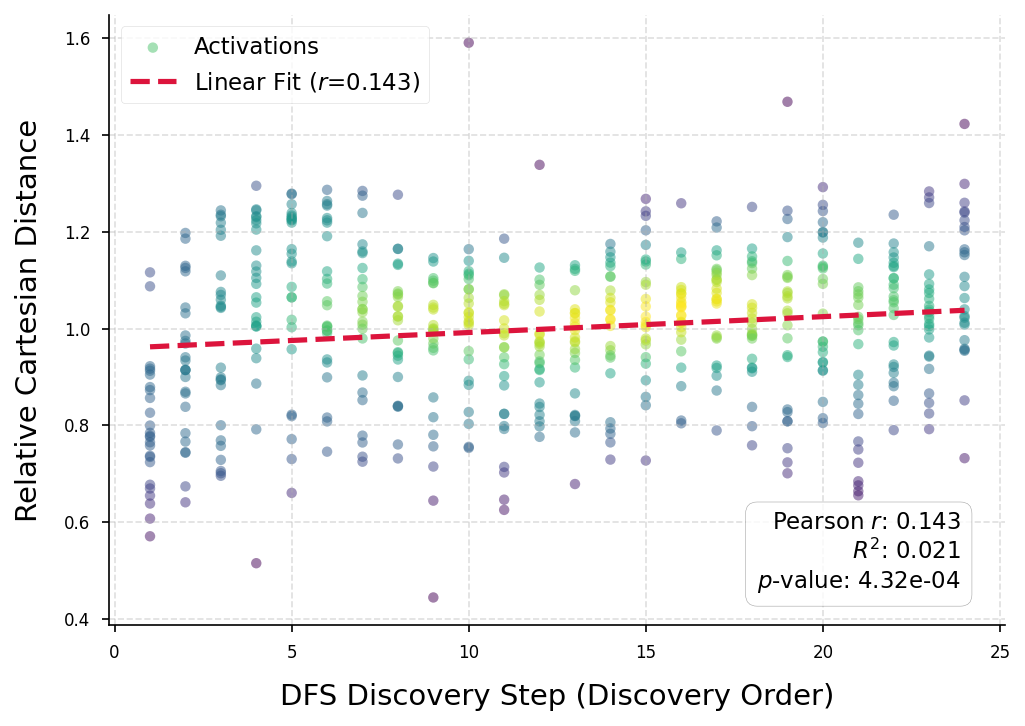

In [242]:
all_dfs_steps = []
all_rel_cartesian_distances = []

for agent_pos_i in range(25):
    mask = (y_agents_flat == agent_pos_i)
    if not torch.any(mask): continue
    
    filtered_activations = reduced_data_pca[mask]
    filtered_y_goals = y_goals[mask]
    
    # Identify agent reference point
    agent_ref_mask = torch.argmax(filtered_y_goals, dim=1) == agent_pos_i
    if not torch.any(agent_ref_mask): continue
    agent_ref_point = np.mean(filtered_activations[agent_ref_mask.numpy()], axis=0)

    # DFS Implementation (Order of discovery)
    dfs_step_map = {}
    stack = [agent_pos_i]
    visited = set()
    counter = 0
    
    while stack:
        curr = stack.pop()
        if curr not in visited:
            visited.add(curr)
            dfs_step_map[curr] = counter
            counter += 1
            
            r, c = divmod(curr, 5)
            # Neighbor order: Right, Down, Left, Up
            for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                nr, nc = r + dr, c + dc
                nb = nr * 5 + nc
                if 0 <= nr < 5 and 0 <= nc < 5 and nb not in visited:
                    stack.append(nb)

    goal_indices = torch.argmax(filtered_y_goals, dim=1).numpy()
    current_agent_cart = []
    current_agent_dfs = []
    
    for j in range(len(filtered_activations)):
        g_idx = goal_indices[j]
        step = dfs_step_map.get(g_idx, 0)
        if step > 0: # Exclude the agent itself (step 0)
            current_agent_cart.append(np.linalg.norm(filtered_activations[j] - agent_ref_point))
            current_agent_dfs.append(step)
            
    if current_agent_cart:
        norm_factor = np.mean(current_agent_cart)
        all_dfs_steps.extend(current_agent_dfs)
        all_rel_cartesian_distances.extend(np.array(current_agent_cart) / norm_factor)

# --- Statistics & Regression ---
x = np.array(all_dfs_steps)
y = np.array(all_rel_cartesian_distances)
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Density for scatter
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

# 1. Density Scatter
sc = ax.scatter(x, y, c=z, s=25, cmap='viridis', alpha=0.5, edgecolors='none', label='Activations')

# 2. Linear Fit
x_range = np.array([x.min(), x.max()])
ax.plot(x_range, intercept + slope * x_range, color='crimson', linestyle='--', linewidth=2.5, 
        label=f'Linear Fit ($r$={r_value:.3f})')


# Labels & Title
ax.set_xlabel('DFS Discovery Step (Discovery Order)', fontsize=14, labelpad=10)
ax.set_ylabel('Relative Cartesian Distance', fontsize=14, labelpad=10)

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(frameon=True, fontsize=11, loc='upper left')

# Stats annotation
stats_text = (f"Pearson $r$: {r_value:.3f}\n"
              f"$R^2$: {r_value**2:.3f}\n"
              f"$p$-value: {p_value:.2e}")
ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.savefig('dfs_vs_cartesian_neurips.png')

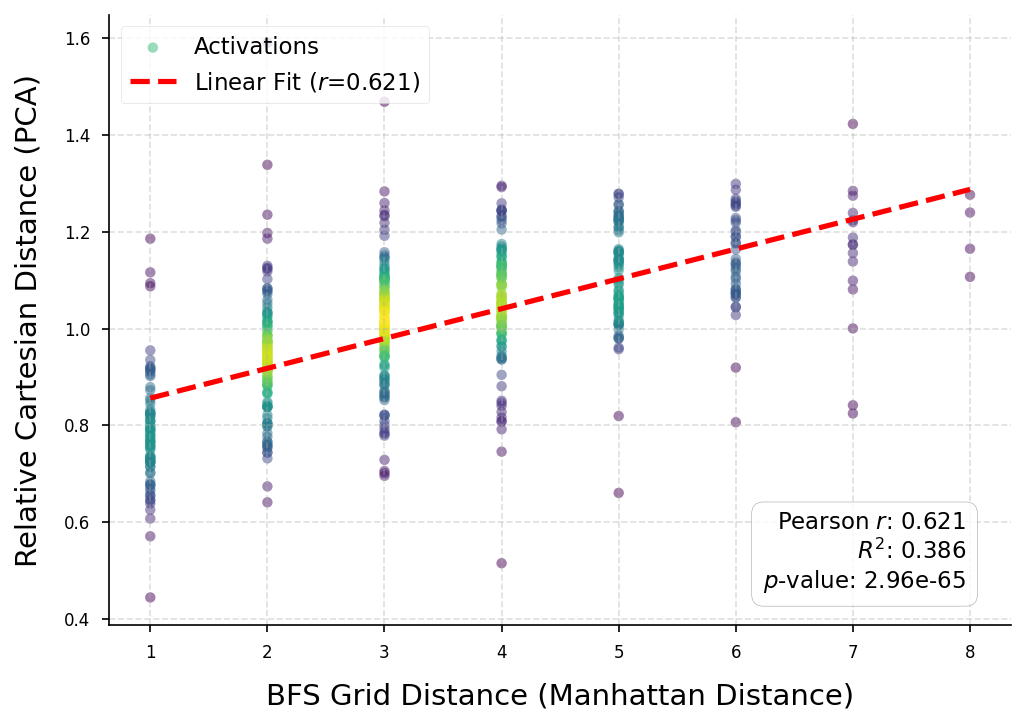

In [241]:
all_bfs_distances = []
all_rel_cartesian_distances = []

for agent_pos_i in range(25):
    mask = (y_agents_flat == agent_pos_i)
    if not torch.any(mask): continue
    
    filtered_activations = reduced_data_pca[mask]
    filtered_y_goals = y_goals[mask]
    
    # Identify agent reference point
    agent_ref_mask = torch.argmax(filtered_y_goals, dim=1) == agent_pos_i
    if not torch.any(agent_ref_mask): continue
    agent_ref_point = np.mean(filtered_activations[agent_ref_mask.numpy()], axis=0)

    # BFS Implementation (Shortest Path Distance)
    bfs_step_map = {agent_pos_i: 0}
    queue = deque([(agent_pos_i, 0)])
    visited = {agent_pos_i}
    
    while queue:
        curr, d = queue.popleft()
        bfs_step_map[curr] = d
        
        r, c = divmod(curr, 5)
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nr, nc = r + dr, c + dc
            nb = nr * 5 + nc
            if 0 <= nr < 5 and 0 <= nc < 5 and nb not in visited:
                visited.add(nb)
                queue.append((nb, d + 1))

    goal_indices = torch.argmax(filtered_y_goals, dim=1).numpy()
    current_agent_cart = []
    current_agent_bfs = []
    
    for j in range(len(filtered_activations)):
        g_idx = goal_indices[j]
        d_grid = bfs_step_map.get(g_idx, 0)
        if d_grid > 0: # Exclude the agent itself (distance 0)
            current_agent_cart.append(np.linalg.norm(filtered_activations[j] - agent_ref_point))
            current_agent_bfs.append(d_grid)
            
    if current_agent_cart:
        # Normalize Cartesian distance by max distance for this agent
        norm_factor = np.mean(current_agent_cart)
        all_bfs_distances.extend(current_agent_bfs)
        all_rel_cartesian_distances.extend(np.array(current_agent_cart) / norm_factor)

# --- Statistics & Regression ---
x = np.array(all_bfs_distances)
y = np.array(all_rel_cartesian_distances)
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Density for scatter
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# --- NeurIPS Pro Plot (BFS Version) ---
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

# 1. Density Scatter (using 'magma' to match the BFS theme used earlier)
sc = ax.scatter(x, y, c=z, s=25, cmap='viridis', alpha=0.5, edgecolors='none', label='Activations')

# 2. Linear Fit
x_range = np.array([x.min(), x.max()])
ax.plot(x_range, intercept + slope * x_range, color='red', linestyle='--', linewidth=2.5, 
        label=f'Linear Fit ($r$={r_value:.3f})')

# Labels & Title
ax.set_xlabel('BFS Grid Distance (Manhattan Distance)', fontsize=14, labelpad=10)
ax.set_ylabel('Relative Cartesian Distance (PCA)', fontsize=14, labelpad=10)
#ax.set_title('Topological Preservation Analysis (BFS Distance)', fontsize=16, fontweight='bold', pad=25)

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(frameon=True, fontsize=11, loc='upper left')

# Stats annotation
stats_text = (f"Pearson $r$: {r_value:.3f}\n"
              f"$R^2$: {r_value**2:.3f}\n"
              f"$p$-value: {p_value:.2e}")
ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))


plt.tight_layout()
plt.savefig('bfs_vs_cartesian_neurips.png')